In [42]:
!pip install optuna
!pip install catboost



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
# EDA for
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
import gc

# Metrics
from sklearn.metrics import (
    mean_squared_error
)

from tensorflow.keras.metrics import RootMeanSquaredError

# Models
from sklearn.linear_model import LinearRegression
import keras_tuner
from keras import *
from keras import Sequential

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import (
    train_test_split,
    KFold,
)
from sklearn.preprocessing import StandardScaler

from catboost import *

# Any
import warnings
warnings.filterwarnings('ignore')

In [44]:
class CFG:
    TARGET = ['nivel_y', 'center_bubbles_px']
    FEATURES = ['temperature', 'air_temp', 'nivel_t']
    N_FOLDS = 20
    RANDOM_STATE = 87


    def dataset_6HZ() -> pd.DataFrame:
        TRAIN_PATH = './data/Stable/Day1/2024_09_02_6hz 19_09-20.csv'
        TRAIN_PATH_AIR = './data/Stable/Day1/2024_09_02_6hz 19_09-20_air.csv'

        TEST_PATH_6HZ = './test/Stable/Day1/2024_09_03_6hz 18_08-19_11.csv'
        TEST_PATH_AIR_6HZ = './test/Stable/Day1/2024_09_03_6hz 18_08-19_11_air.csv'

        train = pd.read_csv(TRAIN_PATH)[:4700].copy()
        train['air_temp'] = pd.read_csv(TRAIN_PATH_AIR)['temperature'][:4700]
        test = pd.read_csv(TEST_PATH_6HZ)[:5700].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_6HZ)['temperature'][:5700]

        return train, test
    

    def dataset_3HZ() -> pd.DataFrame:
        TRAIN_PATH_1 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_1.csv'
        TRAIN_PATH_2 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_2.csv'
        TRAIN_PATH_AIR_1 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_2_air.csv'

        TEST_PATH_3HZ_1 = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_1.csv'
        TEST_PATH_3HZ_2 = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_2.csv'
        TEST_PATH_AIR_3HZ = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_air.csv'

        train = pd.concat([pd.read_csv(TRAIN_PATH_1),
                          pd.read_csv(TRAIN_PATH_2)],ignore_index=True)[:8000].copy()
        train['air_temp'] = pd.read_csv(TRAIN_PATH_AIR_1)['temperature'][:8000]
        test = pd.concat([pd.read_csv(TEST_PATH_3HZ_1),
                               pd.read_csv(TEST_PATH_3HZ_2)],ignore_index=True)[:4700].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_3HZ)['temperature'][:4700]

        return train, test
    

    def dataset_1HZ() -> pd.DataFrame:
        TRAIN_PATH_1 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_1.csv'
        TRAIN_PATH_AIR_1 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_1_air.csv'
        TRAIN_PATH_2 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_2.csv'
        TRAIN_PATH_AIR_2 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_2_air.csv'

        TEST_PATH_1HZ = './test/Stable/Day2/2024_09_03_1hz 16_01-17_35.csv'
        TEST_PATH_AIR_1HZ = './test/Stable/Day2/2024_09_03_1hz 16_01-17_35_air.csv'

        
        train_1 = pd.read_csv(TRAIN_PATH_1).copy()
        train_1['air_temp'] = pd.read_csv(TRAIN_PATH_AIR_1)['temperature']
        train_2 = pd.read_csv(TRAIN_PATH_2).copy()
        train_2['air_temp'] = pd.read_csv(TRAIN_PATH_AIR_2)['temperature']

        train = pd.concat([train_1,train_2],ignore_index=True)
        train = train[:5500]

        test = pd.read_csv(TEST_PATH_1HZ)[:3000].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_1HZ)['temperature'][:3000]

        return train, test


    def dataset_03HZ() -> pd.DataFrame:
        TRAIN_PATH = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01.csv'
        TRAIN_PATH_AIR_1 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_1_air.csv'
        TRAIN_PATH_AIR_2 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_2_air.csv'
        TRAIN_PATH_AIR_3 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_3_air.csv'

        TEST_PATH_03HZ = './test/Stable/Day3/2024_09_03_03hz 19_51-20_35.csv'
        TEST_PATH_AIR_03HZ = './test/Stable/Day3/2024_09_03_03hz 19_51-20_35_air.csv'

        temp = pd.concat([pd.read_csv(TRAIN_PATH_AIR_1),
                          pd.read_csv(TRAIN_PATH_AIR_2),
                          pd.read_csv(TRAIN_PATH_AIR_3)],ignore_index=True)

        train = pd.read_csv(TRAIN_PATH)[300:1000].copy()
        train['air_temp'] = temp['temperature'][300:1000]
        train = train.reset_index(drop=True)

        test = pd.read_csv(TEST_PATH_03HZ)[:1000].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_03HZ)['temperature'][:1000]

        return train, test

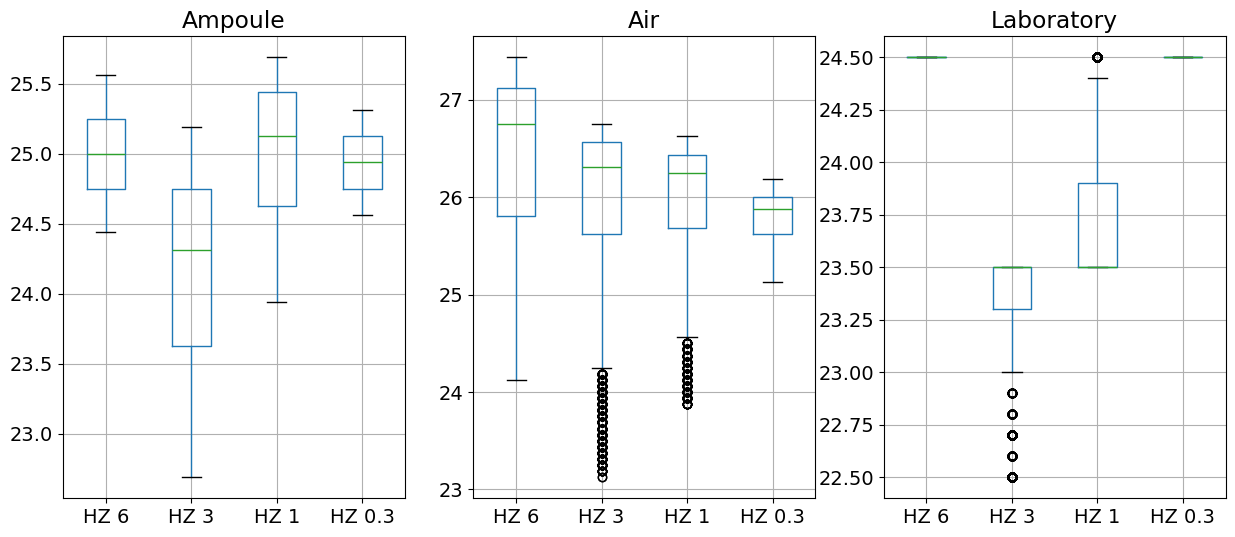

In [45]:
HZ6, _ = CFG.dataset_6HZ()
HZ3, _ = CFG.dataset_3HZ()
HZ1, _ = CFG.dataset_1HZ()
HZ03, _ = CFG.dataset_03HZ()


temp = pd.DataFrame({'HZ 6' : HZ6['temperature'], 
        'HZ 3' : HZ3['temperature'], 
        'HZ 1' : HZ1['temperature'], 
        'HZ 0.3' : HZ03['temperature']})

air_temp = pd.DataFrame({'HZ 6' : HZ6['air_temp'], 
        'HZ 3' : HZ3['air_temp'], 
        'HZ 1' : HZ1['air_temp'], 
        'HZ 0.3' : HZ03['air_temp']})

nivel = pd.DataFrame({'HZ 6' : HZ6['nivel_t'], 
        'HZ 3' : HZ3['nivel_t'], 
        'HZ 1' : HZ1['nivel_t'], 
        'HZ 0.3' : HZ03['nivel_t']})

fig = plt.figure(figsize=(15,6))
ax1 =fig.add_subplot(1,3,1)
temp.boxplot(ax = ax1)
ax1.set_title('Ampoule')
ax2 =fig.add_subplot(1,3,2)
air_temp.boxplot(ax = ax2)
ax2.set_title('Air')
ax3 =fig.add_subplot(1,3,3)
nivel.boxplot(ax = ax3)
ax3.set_title('Laboratory')
plt.show()

In [46]:
train, test = CFG.dataset_1HZ()

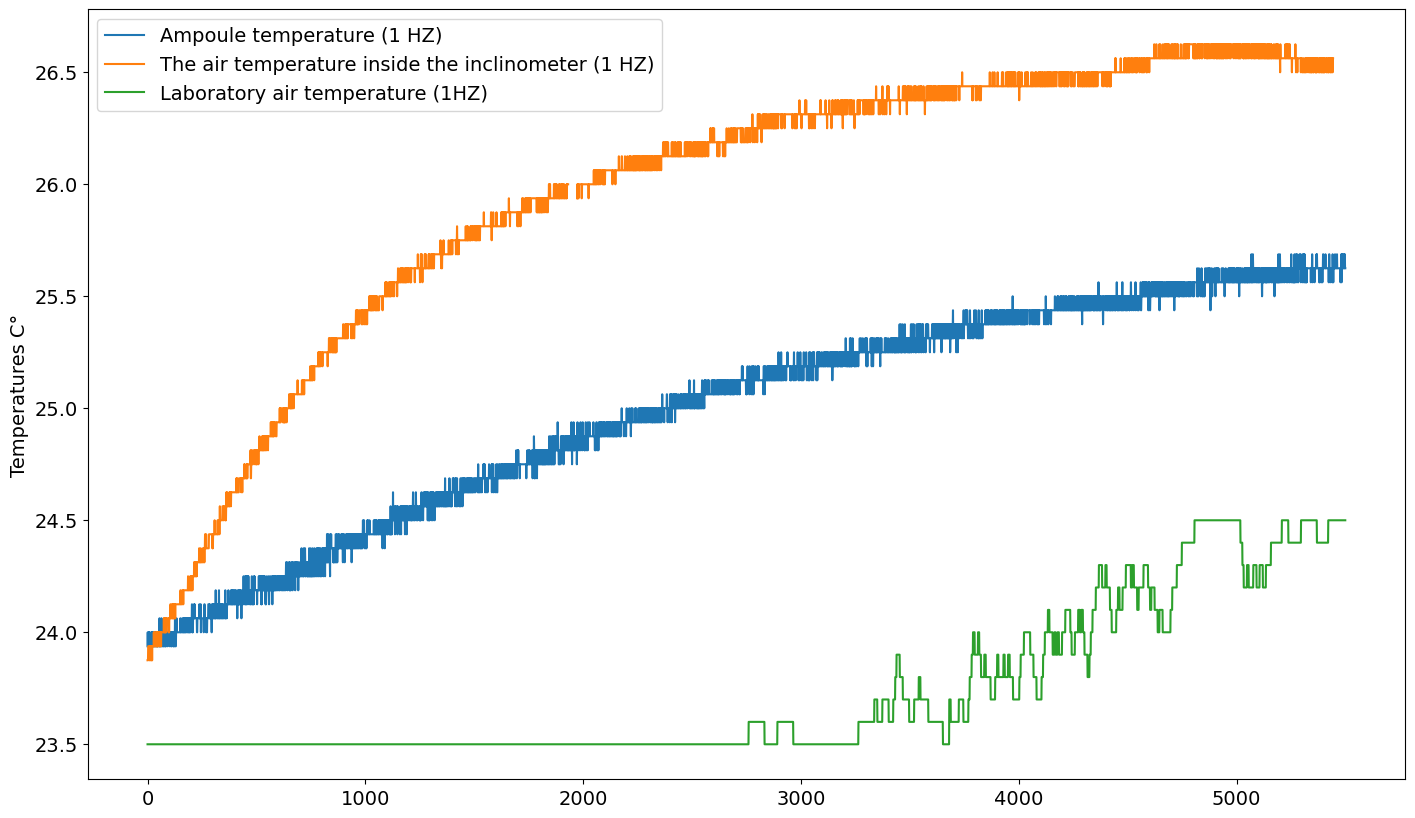

In [47]:
fig,ax = plt.subplots(figsize=(17,10))
plt.rc('font', size=14)          
lns1=ax.plot(train.index,train[['temperature','air_temp', 'nivel_t']])

ax.set_ylabel('Temperatures С°', fontsize=14)

ax.legend(lns1,['Ampoule temperature (1 HZ)',
                'The air temperature inside the inclinometer (1 HZ)',
                'Laboratory air temperature (1HZ)'],fontsize=14)

plt.show()

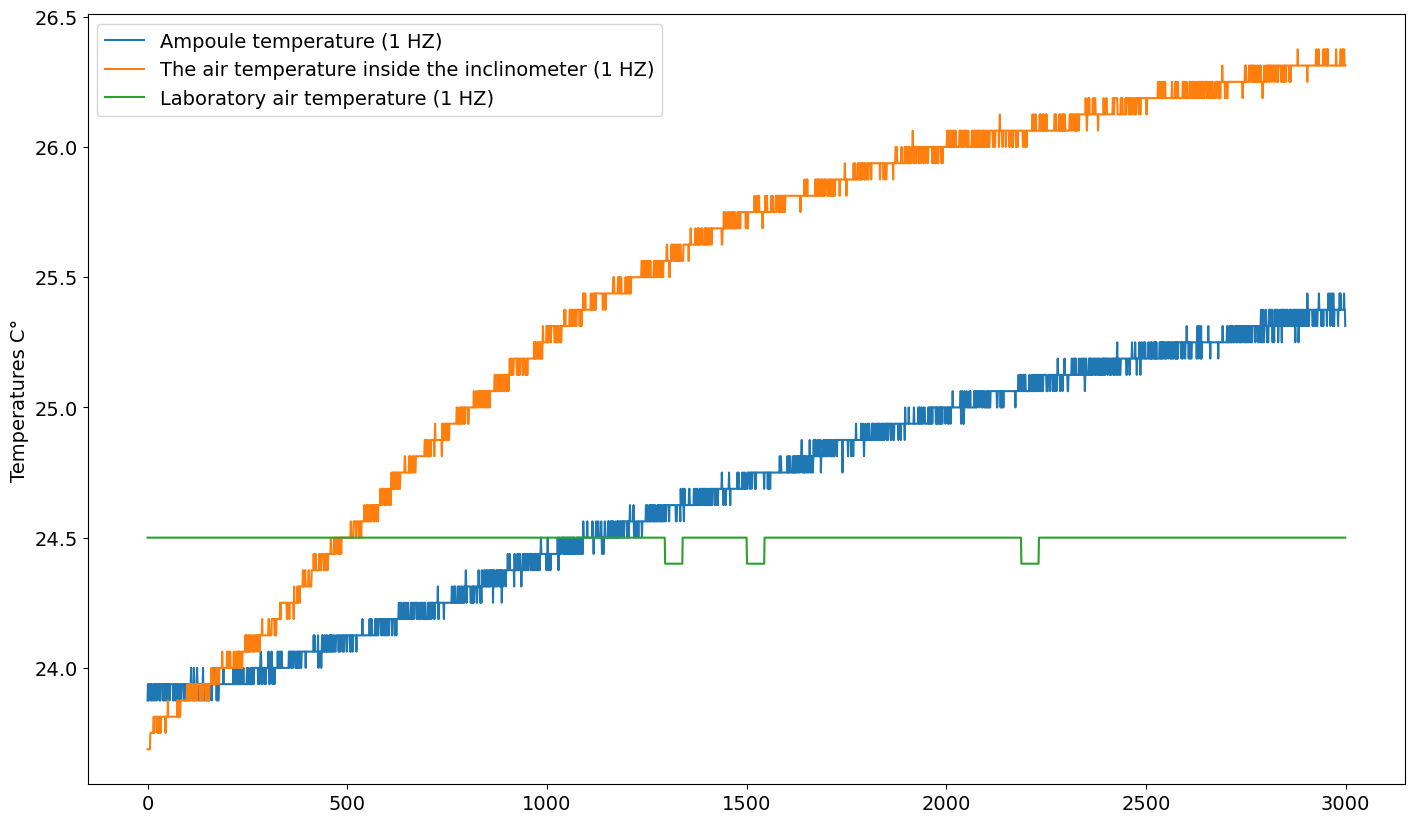

In [48]:
fig,ax = plt.subplots(figsize=(17,10))
plt.rc('font', size=14)          
lns1=ax.plot(test.index,test[['temperature','air_temp', 'nivel_t']])

ax.set_ylabel('Temperatures С°', fontsize=14)

ax.legend(lns1,['Ampoule temperature (1 HZ)',
                'The air temperature inside the inclinometer (1 HZ)',
                'Laboratory air temperature (1 HZ)'],fontsize=14)

plt.show()

In [51]:
train = train.loc[(train['watch_indicator'] != 'False') &
                (train['watch_indicator'] != 'None')]
train = train.drop(columns=['time', 'watch_indicator', 'nivel_x'])

test = test.loc[(test['watch_indicator'] != 'False') &
                (test['watch_indicator'] != 'None')]
test = test.drop(columns=['time', 'watch_indicator', 'nivel_x'])


In [52]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)


train['center_bubbles_px'] = train['center_bubbles_px'].loc[(train['center_bubbles_px'] > -5) & (train['center_bubbles_px'] < 10)]
test['center_bubbles_px'] = test['center_bubbles_px'].loc[(test['center_bubbles_px'] > -5) & (test['center_bubbles_px'] < 10)]

for i in train.columns:
    if i not in [CFG.TARGET, CFG.FEATURES]:
        train[i] = train[i].loc[np.abs(train[i]) < np.abs(train[i].median())*1.25]
        test[i] = test[i].loc[np.abs(test[i]) < np.abs(test[i].median())*1.25]


for i in train.columns:
    if i not in [CFG.TARGET, CFG.FEATURES]:
        train[i] = train[i].interpolate(method='nearest', limit_direction='forward')
        test[i] = test[i].interpolate(method='nearest', limit_direction='forward')

In [58]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train['center_bubbles_px'] *= .003
test['center_bubbles_px'] *= .003

features = train[CFG.FEATURES]
target = train[CFG.TARGET]

# Linear Regression for Ct

slope (95%): 0.004158 +/- 0.000076
intercept (95%): -0.085012 +/- 0.001891


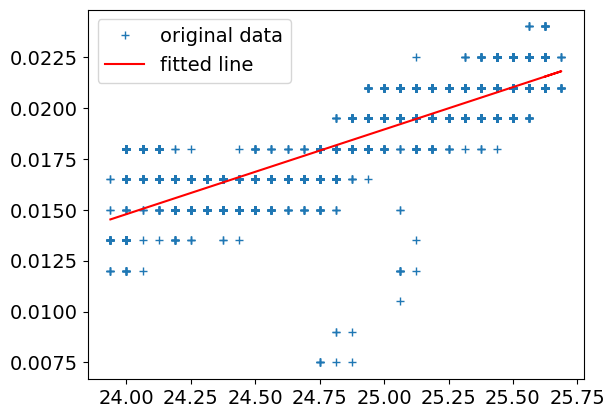

In [60]:
from scipy import stats

res = stats.linregress(features['temperature'], target['center_bubbles_px'])

from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))

ts = tinv(0.05, len(features['temperature'])-2)
print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")

print(f"intercept (95%): {res.intercept:.6f}"
      f" +/- {ts*res.intercept_stderr:.6f}")
# print(f"fitted {res.intercept + res.slope*features['temperature']}")
plt.plot(features['temperature'], target['center_bubbles_px'], '+', label='original data')
plt.plot(features['temperature'], res.intercept + res.slope*features['temperature'], 'r', label='fitted line')
plt.legend()
plt.show()

In [61]:
t_copy = target['center_bubbles_px'].copy()
t_copy -= res.intercept + res.slope*t_copy

In [62]:
np.sqrt(mean_squared_error(target['center_bubbles_px'], t_copy))

0.08493292318698883

In [63]:
dif_l1 = target['center_bubbles_px'] - (t_copy)
dif_l1.mean()

-0.08493292260227088

# Multiple Linear Regression

In [64]:
reg = LinearRegression().fit(features, target)

In [65]:
pred_l = reg.predict(test[CFG.FEATURES])

In [66]:
print("NIVEL:", np.sqrt(mean_squared_error(test[CFG.TARGET[0]], pd.DataFrame(pred_l)[0])))

NIVEL: 0.004480864775576285


In [67]:
print("VIM:", np.sqrt(mean_squared_error(test[CFG.TARGET[1]], pd.DataFrame(pred_l)[1])))

VIM: 0.0011431987398510903


In [68]:
print("MultiRMSE:", np.sqrt(mean_squared_error(test[CFG.TARGET], pred_l)))

MultiRMSE: 0.0032699428508612786


In [69]:
dif_l = test[CFG.TARGET] - (pred_l)
dif_l.mean()

nivel_y             -0.003597
center_bubbles_px    0.000247
dtype: float64

# Cat

In [70]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [72]:
def build_catboost(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 0.01, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', .1, 1., log=True),
        'boosting_type': 'Plain', 
        'task_type': 'GPU',
        'loss_function':'MultiRMSE',
        'eval_metric' : 'MultiRMSE',
    }

    model = CatBoostRegressor(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(features_train, target_train),
        model.get_params(),
        verbose=False
    )
    return np.min(cv_data['test-MultiRMSE-mean'])

In [415]:
study = optuna.create_study(direction="minimize")
study.optimize(build_catboost, n_trials=10)

[I 2024-09-27 13:54:21,143] A new study created in memory with name: no-name-438e9b35-ec1c-411c-a8cc-d8edefeb5af3


Training on fold [0/3]
bestTest = 0.01870534071
bestIteration = 999
Training on fold [1/3]
bestTest = 0.01888558997
bestIteration = 999
Training on fold [2/3]


[I 2024-09-27 13:54:31,870] Trial 0 finished with value: 0.018739136624964237 and parameters: {'learning_rate': 0.0024720823393807774, 'depth': 3, 'l2_leaf_reg': 0.2645037019275201}. Best is trial 0 with value: 0.018739136624964237.


bestTest = 0.0186264792
bestIteration = 999
Training on fold [0/3]
bestTest = 0.004105753482
bestIteration = 999
Training on fold [1/3]
bestTest = 0.004282250574
bestIteration = 999
Training on fold [2/3]


[I 2024-09-27 13:54:44,999] Trial 1 finished with value: 0.004193204053625808 and parameters: {'learning_rate': 0.004701540365882668, 'depth': 5, 'l2_leaf_reg': 0.12940006036039545}. Best is trial 1 with value: 0.004193204053625808.


bestTest = 0.004191608104
bestIteration = 999
Training on fold [0/3]
bestTest = 0.06775516074
bestIteration = 999
Training on fold [1/3]
bestTest = 0.06789792807
bestIteration = 999
Training on fold [2/3]


[I 2024-09-27 13:55:08,798] Trial 2 finished with value: 0.06777315545062286 and parameters: {'learning_rate': 0.0011707918871198238, 'depth': 8, 'l2_leaf_reg': 0.3507935385493586}. Best is trial 1 with value: 0.004193204053625808.


bestTest = 0.06766637754
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2098461911
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2099033045
bestIteration = 999
Training on fold [2/3]


[I 2024-09-27 13:55:36,549] Trial 3 finished with value: 0.209841687077971 and parameters: {'learning_rate': 3.8135922304808535e-05, 'depth': 9, 'l2_leaf_reg': 0.1927038714750361}. Best is trial 1 with value: 0.004193204053625808.


bestTest = 0.2097755657
bestIteration = 999
Training on fold [0/3]
bestTest = 0.003919804691
bestIteration = 998
Training on fold [1/3]
bestTest = 0.004003643777
bestIteration = 999
Training on fold [2/3]


[I 2024-09-27 13:55:42,412] Trial 4 finished with value: 0.003982438837274019 and parameters: {'learning_rate': 0.009331169412063594, 'depth': 1, 'l2_leaf_reg': 0.11369239475512691}. Best is trial 4 with value: 0.003982438837274019.


bestTest = 0.004023858932
bestIteration = 997
Training on fold [0/3]
bestTest = 0.2124845445
bestIteration = 999
Training on fold [1/3]
bestTest = 0.212540534
bestIteration = 999
Training on fold [2/3]


[I 2024-09-27 13:56:09,516] Trial 5 finished with value: 0.21247972849478303 and parameters: {'learning_rate': 2.565321007487756e-05, 'depth': 9, 'l2_leaf_reg': 0.4144602817454509}. Best is trial 4 with value: 0.003982438837274019.


bestTest = 0.212414107
bestIteration = 999
Training on fold [0/3]
bestTest = 0.003616456996
bestIteration = 999
Training on fold [1/3]
bestTest = 0.00371556439
bestIteration = 999
Training on fold [2/3]


[I 2024-09-27 13:56:19,768] Trial 6 finished with value: 0.0037028787080167808 and parameters: {'learning_rate': 0.009408985330020934, 'depth': 6, 'l2_leaf_reg': 0.10847895798450487}. Best is trial 6 with value: 0.0037028787080167808.


bestTest = 0.003775032919
bestIteration = 760
Training on fold [0/3]
bestTest = 0.2160183173
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2160725053
bestIteration = 999
Training on fold [2/3]


[I 2024-09-27 13:56:38,725] Trial 7 finished with value: 0.21601295575888113 and parameters: {'learning_rate': 9.119657715658492e-06, 'depth': 6, 'l2_leaf_reg': 0.4544401740347733}. Best is trial 6 with value: 0.0037028787080167808.


bestTest = 0.2159480446
bestIteration = 999
Training on fold [0/3]
bestTest = 0.04578867369
bestIteration = 999
Training on fold [1/3]
bestTest = 0.04597931358
bestIteration = 999
Training on fold [2/3]


[I 2024-09-27 13:57:15,007] Trial 8 finished with value: 0.04583639257434217 and parameters: {'learning_rate': 0.0015673269827416996, 'depth': 10, 'l2_leaf_reg': 0.6586333872421727}. Best is trial 6 with value: 0.0037028787080167808.


bestTest = 0.04574119046
bestIteration = 999
Training on fold [0/3]
bestTest = 0.08367273773
bestIteration = 999
Training on fold [1/3]
bestTest = 0.08380766548
bestIteration = 999
Training on fold [2/3]


[I 2024-09-27 13:57:35,186] Trial 9 finished with value: 0.08368887476857696 and parameters: {'learning_rate': 0.0009609749540394042, 'depth': 7, 'l2_leaf_reg': 0.9036840973255886}. Best is trial 6 with value: 0.0037028787080167808.


bestTest = 0.08358622109
bestIteration = 999


In [416]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.009408985330020934, 'depth': 6, 'l2_leaf_reg': 0.10847895798450487}
Best RMSE: 0.0037028787080167808


# CB
- Best hyperparameters: {'learning_rate': 0.009408985330020934, 'depth': 6, 'l2_leaf_reg': 0.10847895798450487, 'bagging_temperature': 0.1915764351982925}
- Best RMSE: 0.0037028787080167808

In [417]:
rmses = []
preds = []
skf = KFold(n_splits=CFG.N_FOLDS)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train[CFG.TARGET])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in train.columns if c not in [CFG.TARGET]]]
    y_train = train.loc[train_idx, CFG.TARGET]
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, CFG.TARGET]
    X_test = test[X_train.columns]



    X_train_pool = Pool(X_train, y_train)
    X_valid_pool = Pool(X_valid, y_valid)
    X_test_pool = Pool(X_test)


    model = CatBoostRegressor(
        loss_function='MultiRMSE',
        learning_rate=0.009408985330020934,
        iterations=10000,
        depth=6,
        l2_leaf_reg=0.10847895798450487,
        boosting_type='Plain', 
        task_type='GPU',
        eval_metric='MultiRMSE',
        random_seed=CFG.RANDOM_STATE,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=500, early_stopping_rounds=200)

    pred_valid = model.predict(X_valid_pool)
    preds.append(model.predict(X_test_pool))

    rmse = mean_squared_error(y_valid, pred_valid)**.5
    rmses.append(rmse)
    
    del X_train, y_train, X_valid, y_valid, X_test
    gc.collect()

    print(f'Fold {fold+1} RMSE: {rmse:.5f}\n')

print(f'\nOverall RMSE: {np.median(rmse):.5f} +/- {np.std(rmse):.5f}')

### Fold 1 Training ###
0:	learn: 0.0051297	test: 0.0045405	best: 0.0045405 (0)	total: 3.29ms	remaining: 32.9s
500:	learn: 0.0017452	test: 0.0024304	best: 0.0024304 (500)	total: 1.32s	remaining: 25.1s
1000:	learn: 0.0010689	test: 0.0018587	best: 0.0018587 (996)	total: 2.47s	remaining: 22.2s
1500:	learn: 0.0000607	test: 0.0004384	best: 0.0004384 (1500)	total: 6s	remaining: 34s
2000:	learn: 0.0000109	test: 0.0003642	best: 0.0003642 (2000)	total: 10.5s	remaining: 42.2s
2500:	learn: 0.0000036	test: 0.0003580	best: 0.0003580 (2500)	total: 15s	remaining: 45.1s
3000:	learn: 0.0000016	test: 0.0003561	best: 0.0003561 (2999)	total: 19.9s	remaining: 46.3s
3500:	learn: 0.0000012	test: 0.0003558	best: 0.0003558 (3489)	total: 24.6s	remaining: 45.7s
4000:	learn: 0.0000010	test: 0.0003558	best: 0.0003558 (3997)	total: 29.5s	remaining: 44.2s
4500:	learn: 0.0000009	test: 0.0003557	best: 0.0003557 (4456)	total: 34.3s	remaining: 41.9s
5000:	learn: 0.0000009	test: 0.0003557	best: 0.0003557 (4991)	total: 39

In [727]:
# model.save_model('model_temp_stable_multi')

In [32]:
# model = CatBoostRegressor()
# model.load_model('model_temp_stable_multi')

In [34]:
cat_pred = model.predict(test)

In [35]:
np.sqrt(mean_squared_error(test[CFG.TARGET]['nivel_y'], pd.DataFrame(cat_pred)[0]))

0.009952802193249594

In [36]:
np.sqrt(mean_squared_error(test[CFG.TARGET]['center_bubbles_px'], pd.DataFrame(cat_pred)[1]))

5.188008371964855e-06

In [37]:
np.sqrt(mean_squared_error(test[CFG.TARGET], pd.DataFrame(cat_pred)))

0.007037694878771912

In [38]:
dif = test[CFG.TARGET] - (cat_pred)
dif.mean()

nivel_y             -0.009913
center_bubbles_px    0.000003
dtype: float64

# NN

In [73]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [74]:
features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [75]:
test_nn = scaler.transform(test[CFG.FEATURES])

In [76]:
def build_neural_network(hp):    
    model = Sequential()
    # model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 10)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=6, max_value=24, step=2),
                activation=hp.Choice("activation", ["tanh", "relu","relu6", "leaky_relu", "linear"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.35))
    model.add(layers.Dense(2))
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=[RootMeanSquaredError()]
    )
    return model

In [782]:
build_neural_network(keras_tuner.HyperParameters())

In [783]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_neural_network,
    objective=keras_tuner.Objective('val_loss', 'min'),
    max_trials=20,
    executions_per_trial=3,
    overwrite=True,
)

In [784]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 24, 'step': 2, 'sampling': 'linear'}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'relu', 'relu6', 'leaky_relu', 'linear'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [785]:
tuner.search(features_train, target_train, epochs=10, validation_data=(features_valid, target_valid))

Trial 20 Complete [00h 00m 07s]
val_loss: 0.003808130202742177

Best val_loss So Far: 7.550646993574143e-06
Total elapsed time: 00h 02m 13s


In [786]:
best_NN = build_neural_network(tuner.get_best_hyperparameters()[0])

In [787]:
callback = EarlyStopping(monitor='loss', patience=200)

In [788]:
best_NN.fit(
    features_train,  
    target_train,
    epochs=10000,
    callbacks=[callback]
)

Epoch 1/10000
108/108 [==============================] - 0s 1ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814
Epoch 2/10000
108/108 [==============================] - 0s 1ms/step - loss: 5.9914e-04 - root_mean_squared_error: 0.0245
Epoch 3/10000
108/108 [==============================] - 0s 1ms/step - loss: 1.1237e-04 - root_mean_squared_error: 0.0106
Epoch 4/10000
108/108 [==============================] - 0s 1ms/step - loss: 2.9040e-05 - root_mean_squared_error: 0.0054
Epoch 5/10000
108/108 [==============================] - 0s 1ms/step - loss: 1.9067e-05 - root_mean_squared_error: 0.0044
Epoch 6/10000
108/108 [==============================] - 0s 1ms/step - loss: 1.5572e-05 - root_mean_squared_error: 0.0039
Epoch 7/10000
108/108 [==============================] - 0s 1ms/step - loss: 1.4324e-05 - root_mean_squared_error: 0.0038
Epoch 8/10000
108/108 [==============================] - 0s 1ms/step - loss: 1.3189e-05 - root_mean_squared_error: 0.0036
Epoch 9/10000
108/108 [=====

In [1086]:
# best_NN.save('NN_model_1_best_multi.keras')

In [79]:
# import keras
# best_NN = keras.models.load_model('NN_model_1_best_multi.keras')

In [80]:
ynew = best_NN.predict(test_nn)
class_probabilities = np.hstack((1-ynew, ynew))
pred = pd.DataFrame(ynew)

71/71 [==============================] - 0s 1ms/step


In [81]:
np.sqrt(mean_squared_error(test[CFG.TARGET]['center_bubbles_px'], pred[1]))

0.0016093736052955401

In [82]:
dif_nn = test[CFG.TARGET]['center_bubbles_px'] - pred[1]
dif_nn.mean()

-0.000550825210693663

# Graphics

In [83]:
from keras_visualizer import visualizer

settings = {
    'MAX_NEURONS': None,
    'INPUT_DENSE_COLOR': 'teal',
    'HIDDEN_DENSE_COLOR': 'orange',
    'OUTPUT_DENSE_COLOR': 'crimson'
}



visualizer(best_NN, file_name = 'NN', file_format='png', settings=settings)

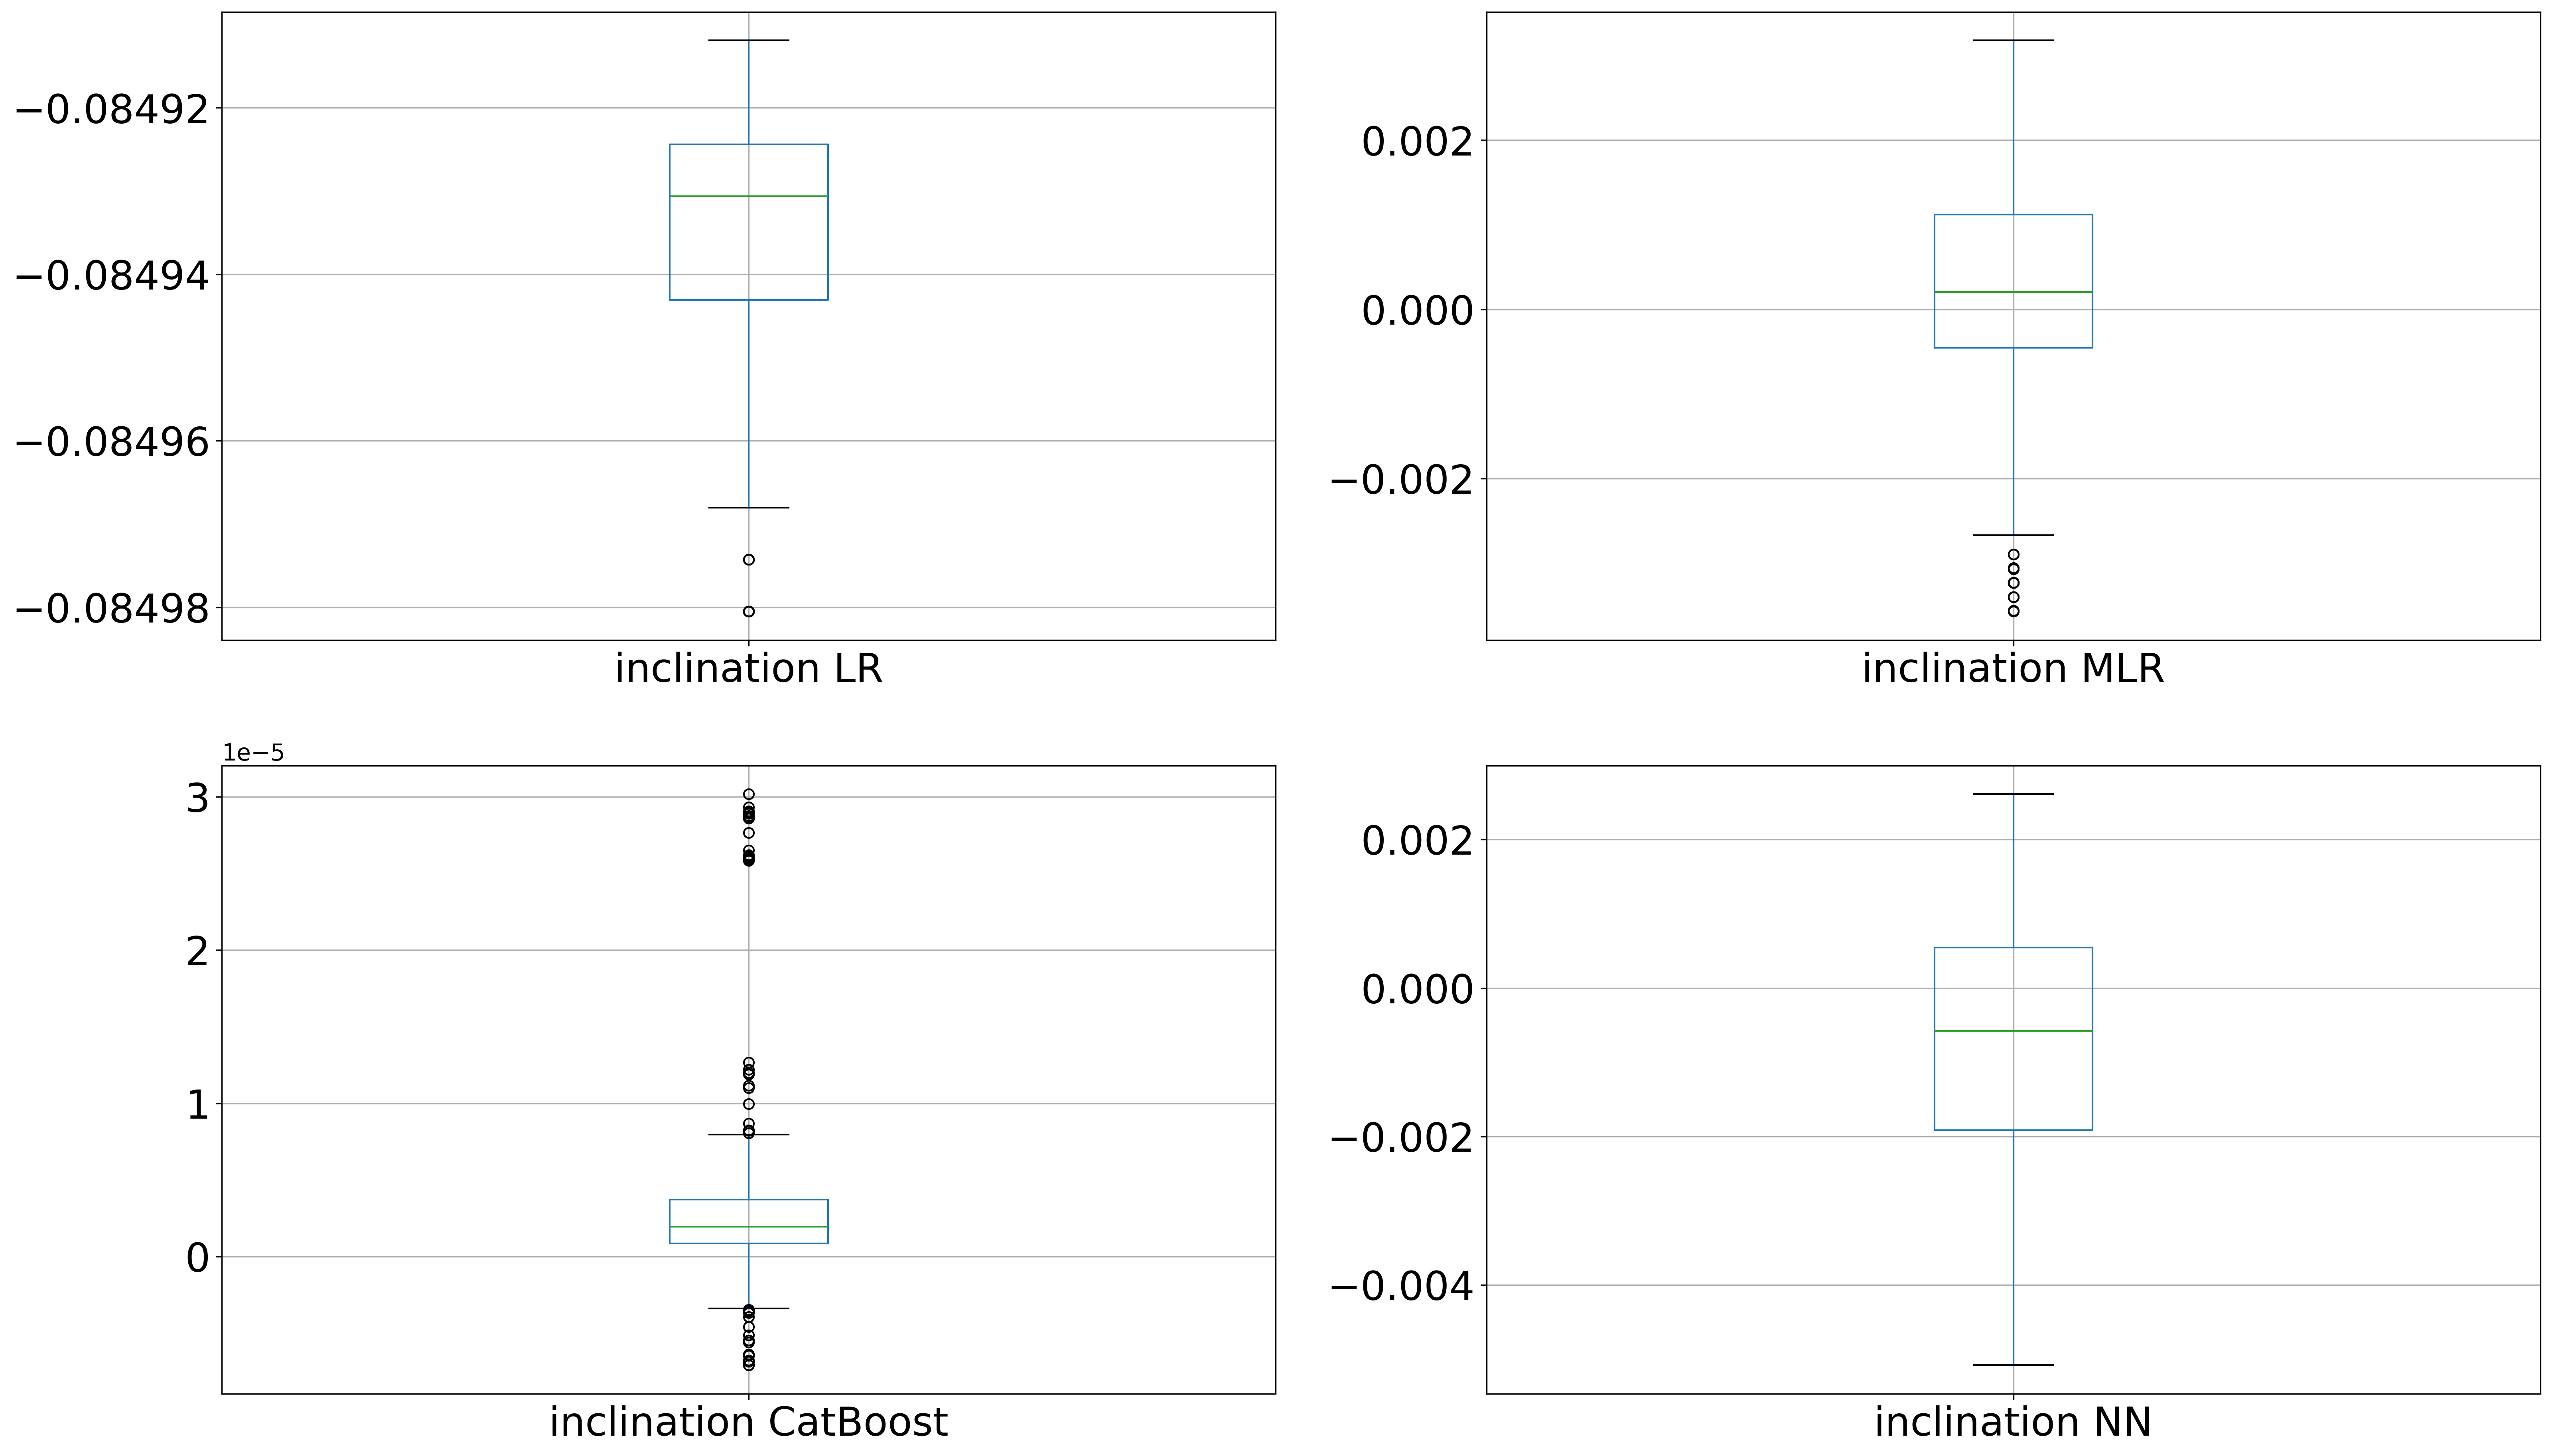

In [86]:
LR = pd.DataFrame({'inclination LR' : dif_l1})
MLR = pd.DataFrame({'inclination MLR' : dif_l['center_bubbles_px']})
CB = pd.DataFrame({'inclination CatBoost' : dif['center_bubbles_px']})
NN = pd.DataFrame({'inclination NN' : dif_nn,})

fig = plt.figure(figsize=(25,15), dpi=300)
ax1 =fig.add_subplot(2,2,1)
LR.boxplot(ax = ax1, showfliers=True, fontsize = 24)
ax2 =fig.add_subplot(2,2,2)
MLR.boxplot(ax = ax2,showfliers=True, fontsize = 24)
ax3 =fig.add_subplot(2,2,3)
CB.boxplot(ax = ax3,showfliers=True, fontsize = 24)
ax4 =fig.add_subplot(2,2,4)
NN.boxplot(ax = ax4,showfliers=True, fontsize = 24)
plt.show()